In [1]:
import os
import ssl
import urllib.request

import cv2
import numpy as np
import logging
import imageio
from skimage import io
from matplotlib import pyplot as plt

from fastapi import FastAPI, BackgroundTasks, Request
from fastapi.middleware.cors import CORSMiddleware
from fastapi.responses import FileResponse, JSONResponse
from PIL import Image, ImageFilter

from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
import torch
from skimage import filters
from numpy import asarray
from PIL import Image, ImageOps

import mediapipe as mp
from pydantic import BaseModel

In [4]:
#== Parameters =======================================================================
BLUR = 21
CANNY_THRESH_1 = 10
CANNY_THRESH_2 = 200
MASK_DILATE_ITER = 10
MASK_ERODE_ITER = 10
MASK_COLOR = (1.0,1.0,1.0)


sam_checkpoint = "./sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)

In [5]:
def get_segments(img_path: str):
    img = cv2.imread('new_img.png')
    masks = mask_generator.generate(img)
    anns = show_anns(masks)
    plt.imsave(img_path, anns)
    
    temp = 255 * anns # Now scale by 255
    segments = temp.astype(np.uint8)
    cv2.imwrite('segments_image.png', segments)
    return masks

def get_lines_from_segments(img_path: str, selectedColor: str):
    img = cv2.imread('segments_image.png')
    gray = cv2.imread('new_img.png')
    # Setting All parameters 
    t_lower = 100  # Lower Threshold
    t_upper = 500  # Upper threshold 
    aperture_size = 5  # Aperture size 
    kernel = np.ones((4,4), np.uint8) 
    NEW_LINE_COLOR = selectedColor  # Set the desired color for lines
    NEW_LINE_COLOR_normalized = [val / 255.0 for val in NEW_LINE_COLOR]
    
    # Applying the Canny Edge filter 
    # with Custom Aperture Size 
    edges = cv2.Canny(img, t_lower, t_upper,  
                    apertureSize=aperture_size) 
    edges = cv2.dilate(edges, kernel)
    edges = cv2.dilate(edges, kernel)
    edges = cv2.erode(edges, kernel)
    
    # Stack arrays in the depth sequence (along the third axis).
    mask_stack = np.dstack([edges]*3)    # Create 3-channel alpha mask

    #-- Blend masked img into MASK_COLOR background --------------------------------------
    mask_stack  = mask_stack.astype('float32') / 255.0          # Use float matrices, 
    img         = img.astype('float32') / 255.0                 #  for easy blending

    masked = (mask_stack * NEW_LINE_COLOR_normalized) + ((1-mask_stack) * MASK_COLOR) # Blend 
    
    cv2.imwrite('edges_image.png', masked)
    cv2.imwrite('edges.png', edges)
    plt.imsave(img_path, masked)

# Downloads an image from the specified URL and saves it to the given path.
def download_image(image_url: str, img_path: str):
    urllib.request.urlretrieve(image_url, img_path)

def remove_background(img_path: str):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    best_mask = get_best_mask(img_path, img)

    # Assuming 'image' is your original image and 'segmentation_mask' is the mask image
    binary_mask = np.where(best_mask > 0.5, 1, 0)

    # Create a new image with the same size and RGBA format
    new_image = np.zeros((img.shape[0], img.shape[1], 4))

    # Use the binary mask to combine the original image and the transparency
    new_image[..., :3] = img * binary_mask[..., np.newaxis]
    new_image[..., 3] = binary_mask * 255


    # Save the result as a PNG file
    cv2.imwrite('new_img.png', new_image)
    new_image = new_image / 255.0

    return new_image
    #plt.imsave(img_path, new_image)

def get_main_color(image_path):
     # Bild öffnen
    image = io.imread(image_path)

    # Bild in ein NumPy-Array konvertieren
    image_array = np.array(image)

    # Die Form des Arrays ändern, um die Pixel als Flachliste zu erhalten
    flattened_image_array = image_array.reshape((-1, 3))

    # Die Hauptfarbe finden, indem der Durchschnitt der RGB-Werte berechnet wird
    main_color = np.mean(flattened_image_array, axis=0)
    
    # Konvertiere die Hauptfarbe in eine Liste von Ganzzahlen
    main_color_list = main_color.astype(int).tolist()

    return main_color_list

def hex_to_rgb(hex_color):
    # Extrahiere die Hexadezimalzahlen für Rot, Grün und Blau
    red = int(hex_color[0:2], 16)
    green = int(hex_color[2:4], 16)
    blue = int(hex_color[4:6], 16)

    return [red, green, blue]

def get_best_mask(img_path: str, img: Image):
    array_image = np.asarray(img)

    predictor = SamPredictor(sam)
    predictor.set_image(array_image)

    input_point = get_inpupt_points(img_path) 
    input_label = np.array([1, 1, 1])

    masks, scores, logits = predictor.predict(
    multimask_output=True,
    point_coords=input_point,
    point_labels=input_label,
    )
    masks.shape 
    best_mask = masks
    currentScore = 0

    for i, (mask, score) in enumerate(zip(masks, scores)):
        if (score > currentScore):
            currentScore = score
            best_mask = mask

    return best_mask

def get_inpupt_points(img_path: str):
    BaseOptions = mp.tasks.BaseOptions
    PoseLandmarker = mp.tasks.vision.PoseLandmarker
    PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
    VisionRunningMode = mp.tasks.vision.RunningMode

    model_path = '/Users/alinameyer/Documents/Master Ol/03 Medienverarbeitung/LineArt/backend/app/models/pose_landmarker_lite.task'

    options = PoseLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=model_path),
        running_mode=VisionRunningMode.IMAGE)

    with PoseLandmarker.create_from_options(options) as landmarker:
        # The landmarker is initialized. Use it here.
        # Load the input image from an image file.
        mp_image = mp.Image.create_from_file(img_path) 
        print(mp_image.width) 
        # Perform pose landmarking on the provided single image.
        # The pose landmarker must be created with the image mode.
        pose_landmarker_result = landmarker.detect(mp_image)          

    img = Image.open(img_path)
    width, height = img.size 

    nose = pose_landmarker_result.pose_landmarks[0][0]
    nose_x = nose.x * width
    nose_y = nose.y * height

    shoulder = pose_landmarker_result.pose_landmarks[0][12]
    shoulder_x = shoulder.x * width
    shoulder_y = shoulder.y * height

    hip = pose_landmarker_result.pose_landmarks[0][23]
    hip_x =hip.x * width
    hip_y = hip.y * height

    input_points = np.array([[nose_x, nose_y], [shoulder_x,shoulder_y], [hip_x, hip_y]])
    return input_points


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    i = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    i[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.99]])
        i[m] = color_mask
    #ax.imshow(i)
    return i


# Opens the image from the given path and applies a box blur effect.
def process_image(img_path: str):
    processedImage = Image.open(img_path)
    processedImage = processedImage.filter(ImageFilter.BoxBlur(10))
    processedImage.save(img_path)
    cv2.imwrite('processedImage.png', processedImage)

def process_image_crop(img_path: str):
    processedImage = io.imread(img_path)
    gray = cv2.cvtColor(processedImage,cv2.COLOR_BGR2GRAY)
    
    #-- Edge detection -------------------------------------------------------------------
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)
    
    #-- Find contours in edges, sort by area ---------------------------------------------
    contour_info = []
    #_, contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Previously, for a previous version of cv2, this line was: 
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Thanks to notes from commenters, I've updated the code but left this note
    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    max_contour = contour_info[0]
    
    #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    cv2.fillConvexPoly(mask, max_contour[0], (255))
    
    # #-- Smooth mask, then blur it --------------------------------------------------------
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
    mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask
    
    #-- Blend masked processedImage into MASK_COLOR background --------------------------------------
    mask_stack  = mask_stack.astype('float32') / 255.0          # Use float matrices, 
    processedImage = processedImage.astype('float32') / 255.0                 #  for easy blending
 
    masked = (mask_stack * processedImage) + ((1-mask_stack) * MASK_COLOR) # Blend
    masked = (masked * 255).astype('uint8')                     # Convert back to 8-bit 
    
    # split image into channels
    c_red, c_green, c_blue = cv2.split(processedImage)

    # merge with mask got on one of a previous steps
    processedImage_a = cv2.merge((c_red, c_green, c_blue, mask.astype('float32') / 255.0))  

    #cv2.imwrite(img_path, processedImage_a*255.0)
    plt.imsave(img_path, processedImage_a)
    
def process_image_contours(img_path: str):
    processedImage = io.imread(img_path)

    gray = cv2.cvtColor(processedImage, cv2.COLOR_BGR2GRAY)

    _, binary = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)

    contours, hierarchy = cv2.findContours(
        binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    drawing = np.zeros((gray.shape[0], gray.shape[1], 3), dtype=np.uint8)
    CountersImg = cv2.drawContours(drawing, contours, -1, (255, 255, 0), 3)

    # save to disk
    plt.imsave(img_path, CountersImg)


1280


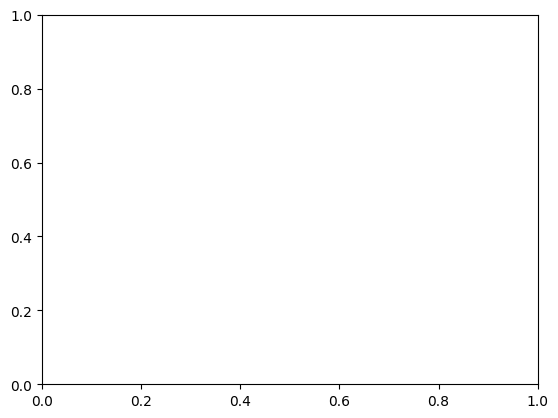

In [7]:
img_path = 'pictures/woman.jpg'
mainColor = get_main_color(img_path)
remove_background(img_path)
masks = get_segments(img_path)

currentOptionContours = "NoColor"    
currentOptionSegments ="NoColor"
selectedColorContours = "#000000"
selectedColorSegments = "#000000"

if currentOptionContours == "NoColor":
    #remove_background('segments_image.png')
    get_lines_from_segments(img_path, hex_to_rgb("000000"))
if currentOptionContours == "Imagebased":
    #remove_background('segments_image.png')
    get_lines_from_segments(img_path, mainColor)
if currentOptionContours == "SelectColorContours":
    get_lines_from_segments(img_path, hex_to_rgb(selectedColorContours))
if currentOptionSegments == "NoColor":
    newColor = "#000000"
    rgb_color = tuple(int(newColor[i:i+2], 16) for i in (2, 4, 6))
    #remove_background('segments_image.png')
    
if currentOptionSegments == "Imagebased":
    #remove_background('segments_image.png')
    print("test")
if currentOptionSegments == "SelectColor":
    newSelectedColor = "#" + selectedColorSegments
    rgb_slectedColor = tuple(int(newSelectedColor[i:i+2], 16) for i in (2, 4, 6))
    #remove_background('segments_image.png')
    #get_lines_from_segments(img_path, rgb_slectedColor)